In [143]:
import numpy as np
import pandas as pd
from scipy import stats
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, interact_manual


%matplotlib inline

sns.set()
import warnings
warnings.filterwarnings('ignore')

In [167]:
#Load the data and infer the date format for the date features

df = pd.read_csv('Bikesales_Features.csv', 
                  parse_dates=['First_Seen','Last_Seen','Last_Modified'], 
                  dtype={'Postcode': 'category'},
                  infer_datetime_format=True)
sport = df[df['Body'] == 'Super Sport'].reset_index(drop=True)
sport.drop(['Description'],axis=1,inplace=True)
sport.head()

,ABS,Adjustable_Seat,Bike,Body,Bore,Cam_Type,Carburettor,Carburettor(s),Charging_Method,Clutch_Type,...,Wet_Operational_Weight,Wheel_Type,Wheelbase,Width,Windscreen,Seller,Brand,Model,Age,Time_to_Sale
0,No,No,250 R Road Manual 5sp 250cc,Super Sport,77.0,SOHC (Single Over Head Cam),Electronic fuel injection,1.0,Engine,Multi plate,...,136.000000,Spoke,1350.0,818.262,Standard,Private,Megelli,250 r,6,43.0
1,No,No,CBR900RR Fireblade,Super Sport,74.0,DOHC (Double Over Head Cam),Electronic fuel injection,4.0,Engine,Multi plate,...,224.660085,Spoke,1397.0,680.000,Standard,Private,Honda,Cbr900rr fireblade 929,19,43.0
2,No,No,CBR125R Road Manual 6sp 125cc,Super Sport,58.0,SOHC (Single Over Head Cam),Electronic fuel injection,1.0,Engine,Multi plate,...,114.000000,Spoke,1294.0,675.000,Standard,Dealer,Honda,Cbr125r,12,43.0
3,No,No,VJF250 MY12 Road Manual 5sp,Super Sport,73.0,DOHC (Double Over Head Cam),Electronic fuel injection,1.0,Engine,Multi plate,...,141.000000,Spoke,1380.0,764.000,Standard,Private,Daelim,Vjf250,8,43.0
4,No,No,CBR125R Road Manual 6sp 125cc,Super Sport,58.0,SOHC (Single Over Head Cam),Electronic fuel injection,1.0,Engine,Multi plate,...,114.000000,Spoke,1294.0,675.000,Standard,Private,Honda,Cbr125r,11,43.0


# Remove Outliers

In [168]:
subset = sport.select_dtypes(include='number')
# Calculate the z score
z = np.abs(stats.zscore(subset))
# convert into a dataframe
z = pd.DataFrame(z,columns=subset.columns)

# Add in the categorical features before removeing outliers
for col in sport.select_dtypes(exclude='number').columns:
    z[col] = 0

# Order the feature list to the z value feature list
subset = sport[z.columns]
# Filter out the outliers
subset_o = subset[(z < 3).all(axis=1)]

sport = subset_o

In [169]:
sport.shape

(2177, 93)

# Remove Colinear features


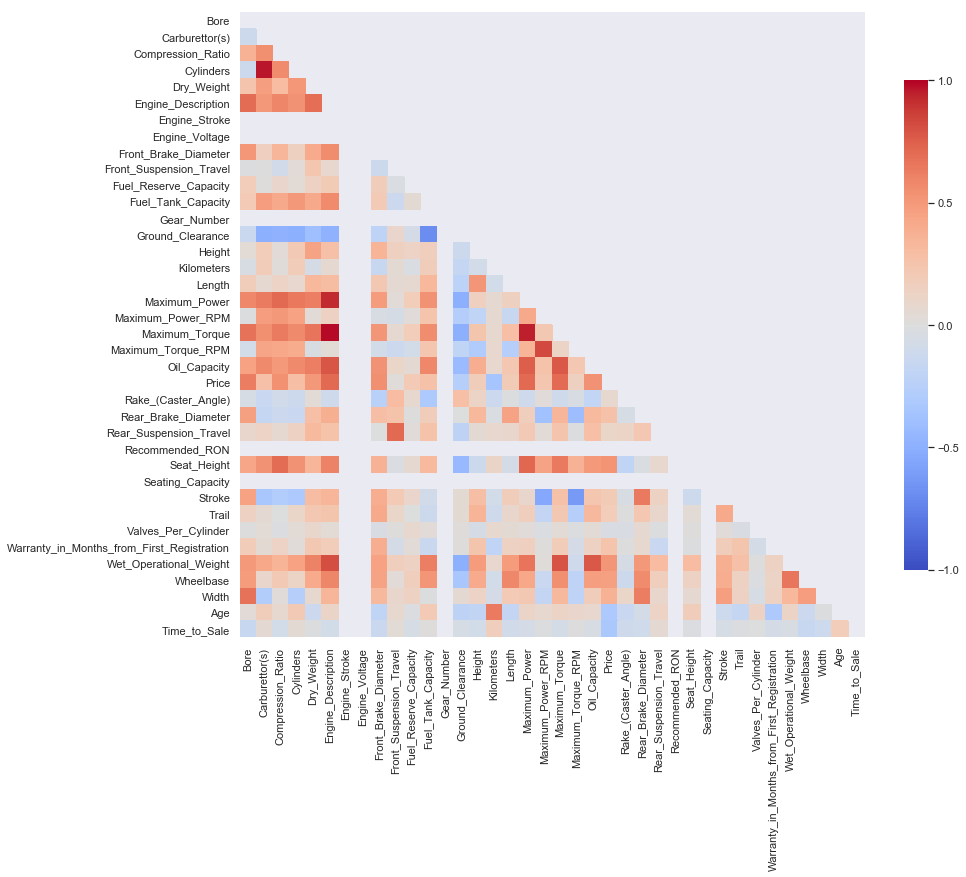

In [170]:
def display_correlation_matrix(df):
    corr_matrix = df.corr()
    mask = np.zeros_like(corr_matrix, dtype=np.bool)
    mask[np.triu_indices_from(mask)]= True

    f, ax = plt.subplots(figsize=(14, 15)) 

    heatmap = sns.heatmap(corr_matrix, mask = mask,square = True,
                          cmap = 'coolwarm', cbar_kws = {'shrink': .6, 'ticks' : [-1, -.5, 0, 0.5, 1]}, 
                          vmin = -1, vmax = 1)

    #add the column names as labels
    ax.set_yticklabels(corr_matrix.columns, rotation = 0)
    ax.set_xticklabels(corr_matrix.columns);


display_correlation_matrix(sport)

In [171]:
def filter_Colinear_Features(df, target, threshold = 0.8):
    drop_list = []

    for col1 in df.select_dtypes(include='number').columns:
        for col2 in df.select_dtypes(include='number').columns:
            if (col1 == col2):
                continue

            correlation = abs(df[col1].corr(df[col2]))

            if correlation > threshold:
                
                col1_corr = abs(df[col1].corr(df[target]))
                col2_corr = abs(df[col2].corr(df[target]))
            
                print (col1, col1_corr, col2, col2_corr)
            
                if col1_corr > col2_corr:
                    drop_list.append(col2)
                    
                else:
                    drop_list.append(col1)


    return list(set(drop_list))


drop_list = filter_Colinear_Features(sport, 'Price', threshold = 0.8)
drop_list

Carburettor(s) 0.28120323812126824 Cylinders 0.2920393048351623
Cylinders 0.2920393048351623 Carburettor(s) 0.28120323812126824
Engine_Description 0.7117315924368668 Maximum_Power 0.7186811283984942
Engine_Description 0.7117315924368668 Maximum_Torque 0.7091546838902215
Engine_Description 0.7117315924368668 Wet_Operational_Weight 0.5167058918055526
Maximum_Power 0.7186811283984942 Engine_Description 0.7117315924368668
Maximum_Power 0.7186811283984942 Maximum_Torque 0.7091546838902215
Maximum_Power_RPM 0.24169114471005515 Maximum_Torque_RPM 0.1491315440051495
Maximum_Torque 0.7091546838902215 Engine_Description 0.7117315924368668
Maximum_Torque 0.7091546838902215 Maximum_Power 0.7186811283984942
Maximum_Torque_RPM 0.1491315440051495 Maximum_Power_RPM 0.24169114471005515
Wet_Operational_Weight 0.5167058918055526 Engine_Description 0.7117315924368668


['Maximum_Torque_RPM',
 'Engine_Description',
 'Wet_Operational_Weight',
 'Carburettor(s)',
 'Maximum_Torque']

In [172]:

#sport.drop(list(set(drop_list)),axis=1,inplace=True)
#sport.columns


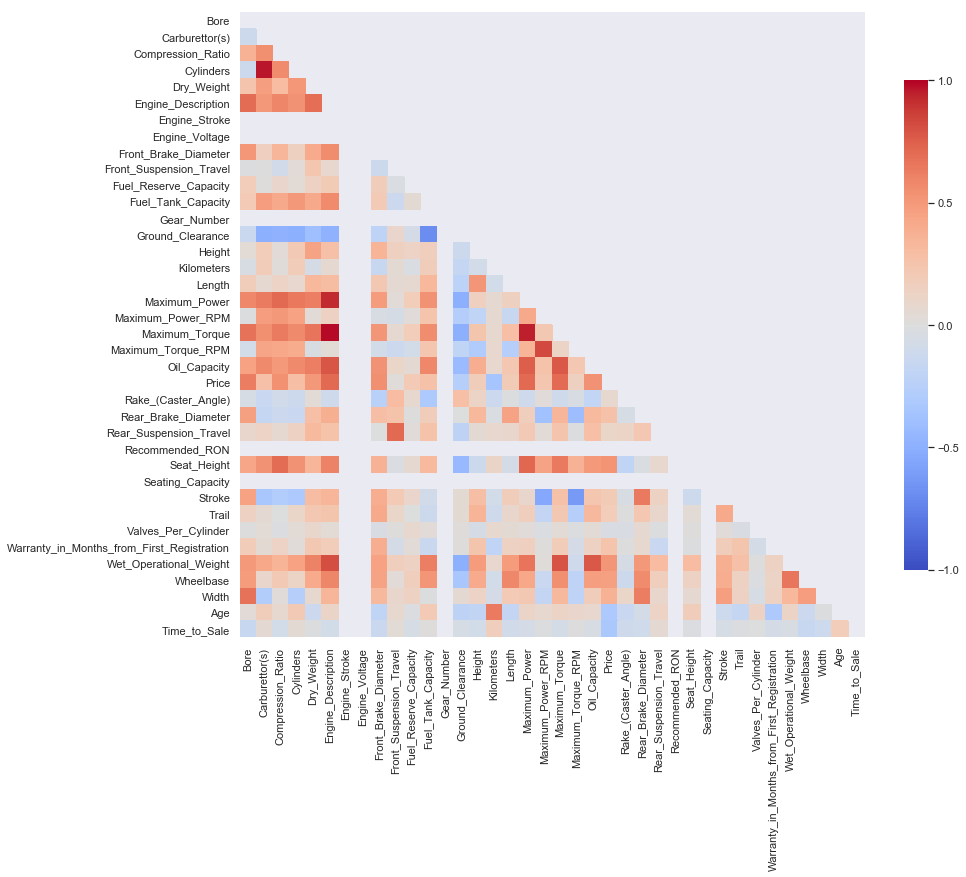

In [173]:
display_correlation_matrix(sport)

In [174]:

sport.to_csv('clean_sport.csv',index=False)

# Explore the features

In [175]:
def scatter(data,x,y,hue=None,title='',figsize=(12,10)):
    ax = plt.figure(figsize=figsize)
    sns.scatterplot(x=x,y=y,hue=hue,data=data);
    plt.title(title,fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)



def count_plot(data, feature,figsize=(12,10)):
    ax = data[feature].value_counts().sort_values().plot(kind='bar',figsize=figsize);
    ax.set_xlabel(feature);
    ax.set_ylabel('Counts');
    ax.set_title('Distribution of '+feature);
  


In [176]:
@interact
def plot_counts(column=sport.select_dtypes(exclude='number')):
    # remove the description 
    #column = set(list(sport.select_dtypes(exclude='number').columns)) - set(['Description'])
    
    sport[column].value_counts(normalize=True).plot(kind='bar',figsize=(12,10))
    plt.title('Distribution of Bikes',fontsize=16)
    plt.xlabel(column)
    plt.ylabel('Percentage of Bikes')
    
    


interactive(children=(Dropdown(description='column', options=('ABS', 'Adjustable_Seat', 'Bike', 'Body', 'Cam_T…

In [177]:
@interact
def plot_counts(Feature=sport.select_dtypes(include='number')):
    # remove the description 
    #column = set(list(sport.select_dtypes(exclude='number').columns)) - set(['Description'])
    correlation = sport[Feature].corr(sport['Price'])
    ax = sns.jointplot(Feature,'Price', data=sport, kind='reg')
    plt.gcf().set_size_inches(10,10)
    ax.annotate(stats.pearsonr)
    plt.suptitle('Relationship to Price',x=0.5,y=1.01,size=18)
    plt.xlabel(Feature)


interactive(children=(Dropdown(description='Feature', options=('Bore', 'Carburettor(s)', 'Compression_Ratio', …

In [178]:
Remove_outliers = ['Price',
                   'Bore','Compression_Ratio','Fuel_Reserve_Capacity','Length',
                   'Maximum_Power_RPM','Maximum_Torque','Maximum_Torque_RPM','Wheelbase',
                   'Wet_Operational_Weight','Trail','Rear_Susspension_Travel',
                   'Rear_Brake_Diameter']


In [179]:

# No variability in feature
no_variability = ['Adjustable_Seat','Body','Fuel_Type','Engine_Voltage','Gear_Number',
                  'Seating_Capacity','Recommended_RON','Drive_Type','Windscreen','Gear_Type']
no_value = ['URL','Network_ID','Engine_Stroke','Valves_Per_Cylinder',
           'Rake_(Caster_Angle)']

needs_reduction = ['Bike','Model']

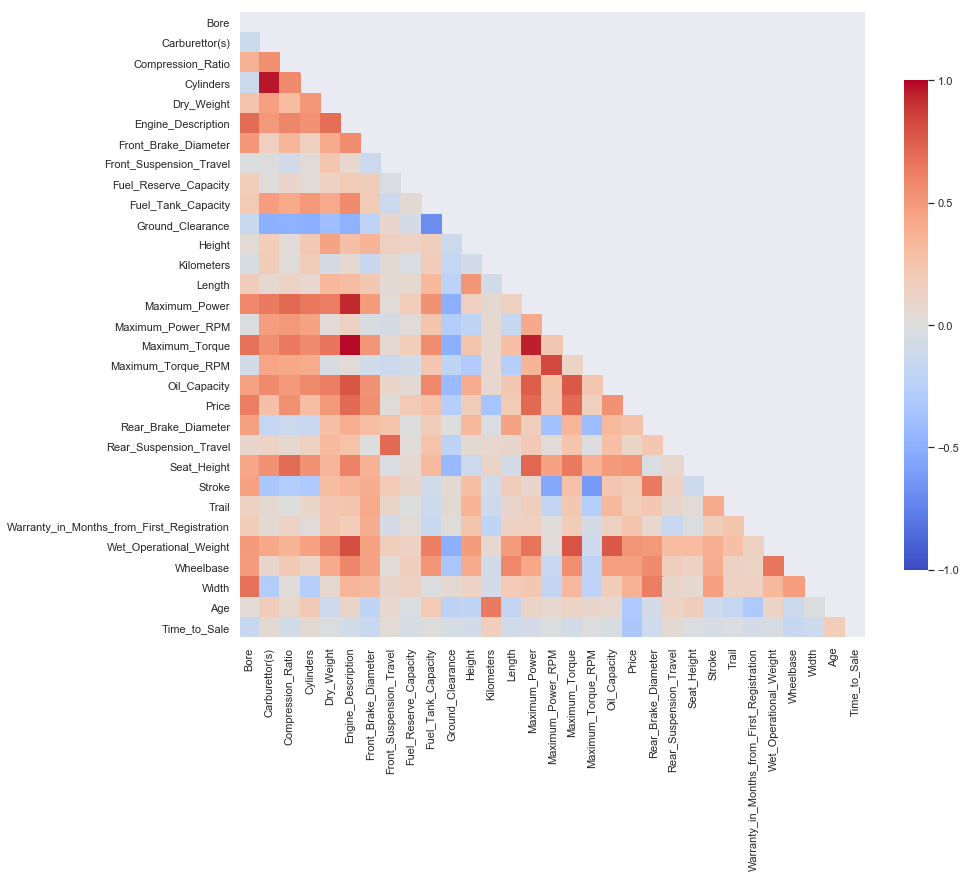

In [180]:

sport.drop(no_variability, axis=1, inplace=True)
sport.drop(no_value, axis=1, inplace=True)

display_correlation_matrix(sport)

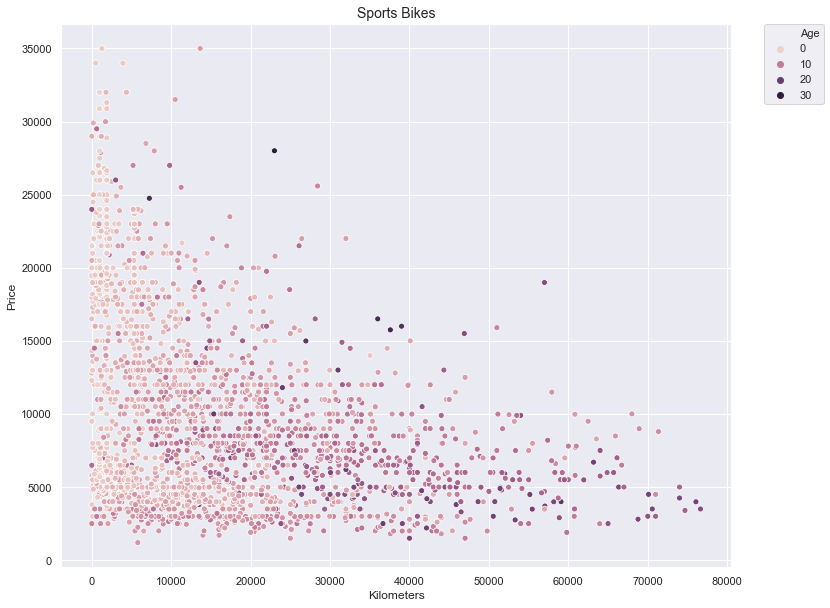

In [181]:
scatter(sport,'Kilometers','Price',hue='Age',title='Sports Bikes')

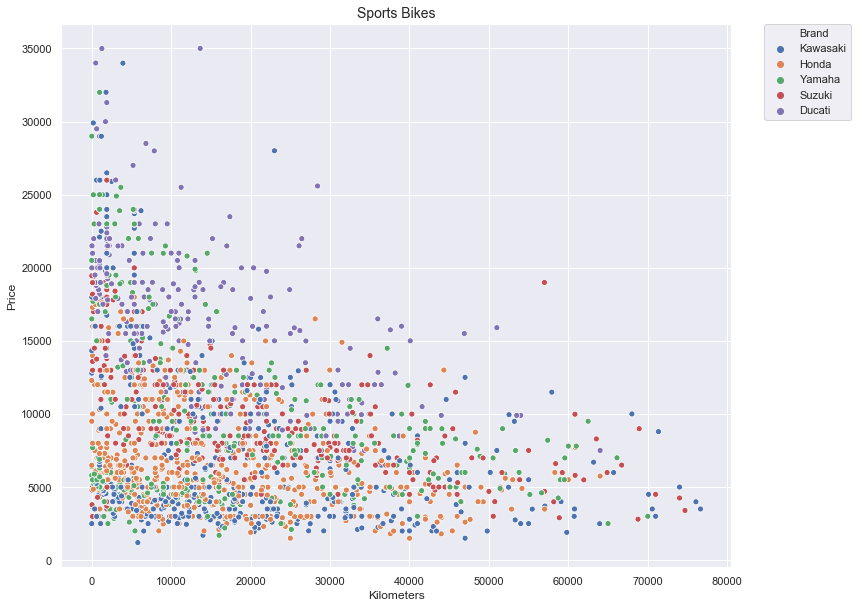

In [182]:
# Take the top 5 brands
top_5brands = sport['Brand'].value_counts(sort=True).index[:5]
top5 = sport[sport['Brand'].isin(top_5brands) == True].reset_index(drop=True)
top5.head()


scatter(top5,'Kilometers','Price',hue='Brand',title='Sports Bikes')

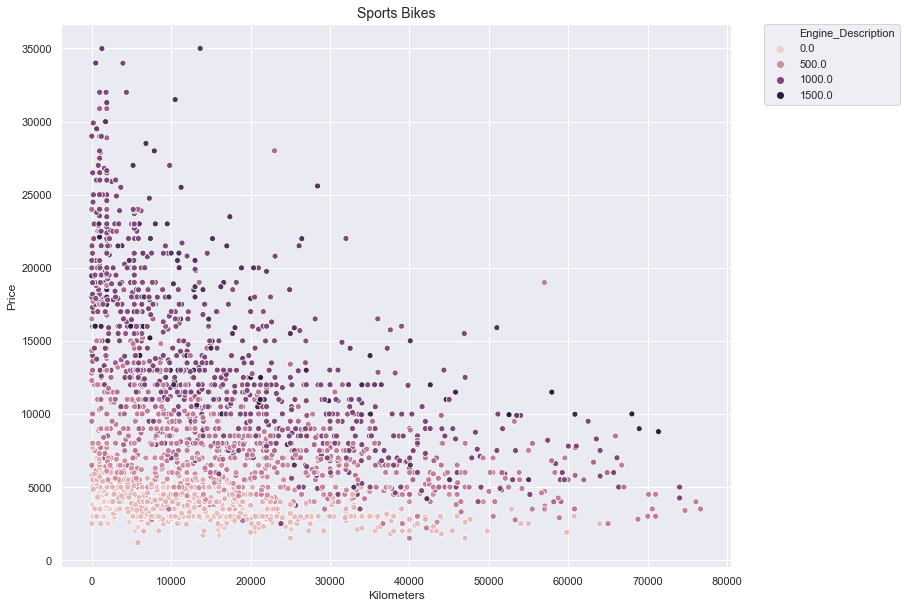

In [183]:

scatter(sport,'Kilometers','Price',hue='Engine_Description',title='Sports Bikes')

In [184]:
sport['Engine_Description'].unique()

array([ 250.,  150.,  125.,  600.,  300.,  650.,  636., 1000.,  500.,
        750.,  929., 1200.,  954.,  675.,  999.,  749.,  848.,  800.,
       1300., 1098., 1400.,  996.,  899., 1199.,  950.,  998.,  959.,
        916., 1198., 1100.,  400.,  599.])

In [252]:

@interact
def plot_counts(Feature=sport.select_dtypes(include='number'),Hue=sport.select_dtypes(exclude='number')):
    hue_list = list(sport[Hue].unique())
    correlation = sport[Feature].corr(sport['Price'])
    #ax = plt.figure(figsize=(12,10))
    sns.lmplot(x=Feature, y='Price', hue=Hue, data=sport, fit_reg=False, 
               height=10,aspect=1.2,scatter_kws={'alpha':0.3})
    for idx, h in enumerate(hue_list):
        subset = sport[sport[Hue] == h]
        correlation = subset[Feature].corr(subset['Price'])
        ypos = 0.95 - idx*0.025
        plt.gca().annotate(f'{h}:',xy=(0.87, ypos), xycoords='figure fraction', fontsize=14)
        plt.gca().annotate(f'{correlation:.3f}',xy=(0.95, ypos), xycoords='figure fraction', fontsize=14)

    plt.title('Relationship to Price',fontsize=18)
    plt.xlabel(Feature);



interactive(children=(Dropdown(description='Feature', options=('Bore', 'Carburettor(s)', 'Compression_Ratio', …

In [253]:
@interact
def plot_counts(Feature=top5.select_dtypes(include='number'),Hue=top5.select_dtypes(exclude='number')):
    hue_list = list(top5[Hue].unique())
    correlation = top5[Feature].corr(top5['Price'])
    sns.lmplot(x=Feature, y='Price', hue=Hue, data=top5, fit_reg=False, 
               height=10,aspect=1.2,scatter_kws={'alpha':0.3})
    for idx, h in enumerate(hue_list):
        subset = top5[top5[Hue] == h]
        correlation = subset[Feature].corr(subset['Price'])
        ypos = 0.95 - idx*0.025
        plt.gca().annotate(f'{h}:',xy=(0.87, ypos), xycoords='figure fraction', fontsize=14)
        plt.gca().annotate(f'{correlation:.3f}',xy=(0.95, ypos), xycoords='figure fraction', fontsize=14)

    plt.title('Top 5 Brands',fontsize=18)
    plt.xlabel(Feature);



interactive(children=(Dropdown(description='Feature', options=('Bore', 'Carburettor(s)', 'Compression_Ratio', …

In [254]:
top5.head()

,Bore,Carburettor(s),Compression_Ratio,Cylinders,Dry_Weight,Engine_Description,Front_Brake_Diameter,Front_Suspension_Travel,Fuel_Reserve_Capacity,Fuel_Tank_Capacity,...,Starter,State,Suburb,Swingarm_Type,Traction_Control,Warranty_KMs,Wheel_Type,Seller,Brand,Model
0,62.0,2.0,11.0,2.0,152.0,250.0,290.0,120.0,3.459387,18.0,...,Electric,QLD,Ashgrove,Dual Sided,No,No,Spoke,Private,Kawasaki,Ninja 250r ex250j
1,62.0,2.0,11.0,2.0,129.0,250.0,290.0,120.0,3.459387,18.0,...,Electric,WA,South perth,Dual Sided,No,No,Spoke,Private,Kawasaki,Ninja 250r special edition
2,62.0,2.0,11.0,2.0,152.0,250.0,290.0,120.0,3.459387,18.0,...,Electric,QLD,Arana hills,Dual Sided,No,No,Spoke,Private,Kawasaki,Ninja 250r ex250j
3,62.0,2.0,11.0,2.0,152.0,250.0,290.0,120.0,3.459387,18.0,...,Electric,WA,none,Dual Sided,No,No,Spoke,Dealer,Kawasaki,Ninja 250r ex250j
4,48.6,4.0,10.0,4.0,129.0,250.0,296.0,118.0,3.459387,13.0,...,Electric,WA,none,Dual Sided,No,No,Spoke,Dealer,Honda,Cbr250r


In [255]:
top5.shape

(1988, 78)

In [93]:
@interact
def correlations(column1=sport.select_dtypes(include='number'),
                column2=sport.select_dtypes(include='number')):
    print(sport[column1].corr(sport[column2]))


interactive(children=(Dropdown(description='column1', options=('Bore', 'Compression_Ratio', 'Cylinders', 'Dry_…

# Numerical features

In [107]:
numerical = sport.select_dtypes(include='number').columns
numerical

Index(['Bore', 'Compression_Ratio', 'Cylinders', 'Dry_Weight',
       'Front_Brake_Diameter', 'Front_Suspension_Travel',
       'Fuel_Reserve_Capacity', 'Fuel_Tank_Capacity', 'Ground_Clearance',
       'Height', 'Kilometers', 'Length', 'Maximum_Power', 'Maximum_Power_RPM',
       'Oil_Capacity', 'Price', 'Rear_Brake_Diameter',
       'Rear_Suspension_Travel', 'Seat_Height', 'Stroke', 'Trail',
       'Warranty_in_Months_from_First_Registration', 'Wheelbase', 'Width',
       'Age', 'Time_to_Sale'],
      dtype='object')

In [108]:
# Create some supporting plotting functions
def plot_scatter_grid(data, possible_predictors,col=4):
    
    row = int(len(possible_predictors)/col)+1
    
    
    target = data['Price']
    fig = plt.figure(figsize=(20,row*4))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    for idx, predictor in enumerate(possible_predictors):
        ax = fig.add_subplot(row, col, idx+1)
        plt.scatter(data[predictor], target, s=1)
        ax.set_title(predictor)
        
def plot_distribution_grid(data, possible_predictors,col=4):
    
    row = int(len(possible_predictors)/col)+1
    
    target = data['Price']
    fig = plt.figure(figsize=(20,row*4))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    for idx, predictor in enumerate(possible_predictors):
        plot_data = data[predictor][data[predictor].isnull() == False]
        ax = fig.add_subplot(row, col, idx+1)
        sns.distplot(plot_data)
        ax.set_title(predictor)
        
def plot_box_grid(data, possible_predictors,col=4):
    
    row = int(len(possible_predictors)/col)+1
    
    target = data['Price']
    fig = plt.figure(figsize=(20,row*4))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    for idx, predictor in enumerate(possible_predictors):
        ax = fig.add_subplot(row, col, idx+1)
        sns.boxplot(x=data[predictor])
        ax.set_title(predictor)


def plot_correlation_matrix(data,figsize=(15,15)):
    corr_mat=data.corr(method='pearson')
    plt.figure(figsize=figsize)
    sns.heatmap(corr_mat,vmax=1,square=True,annot=True,cmap='cubehelix')

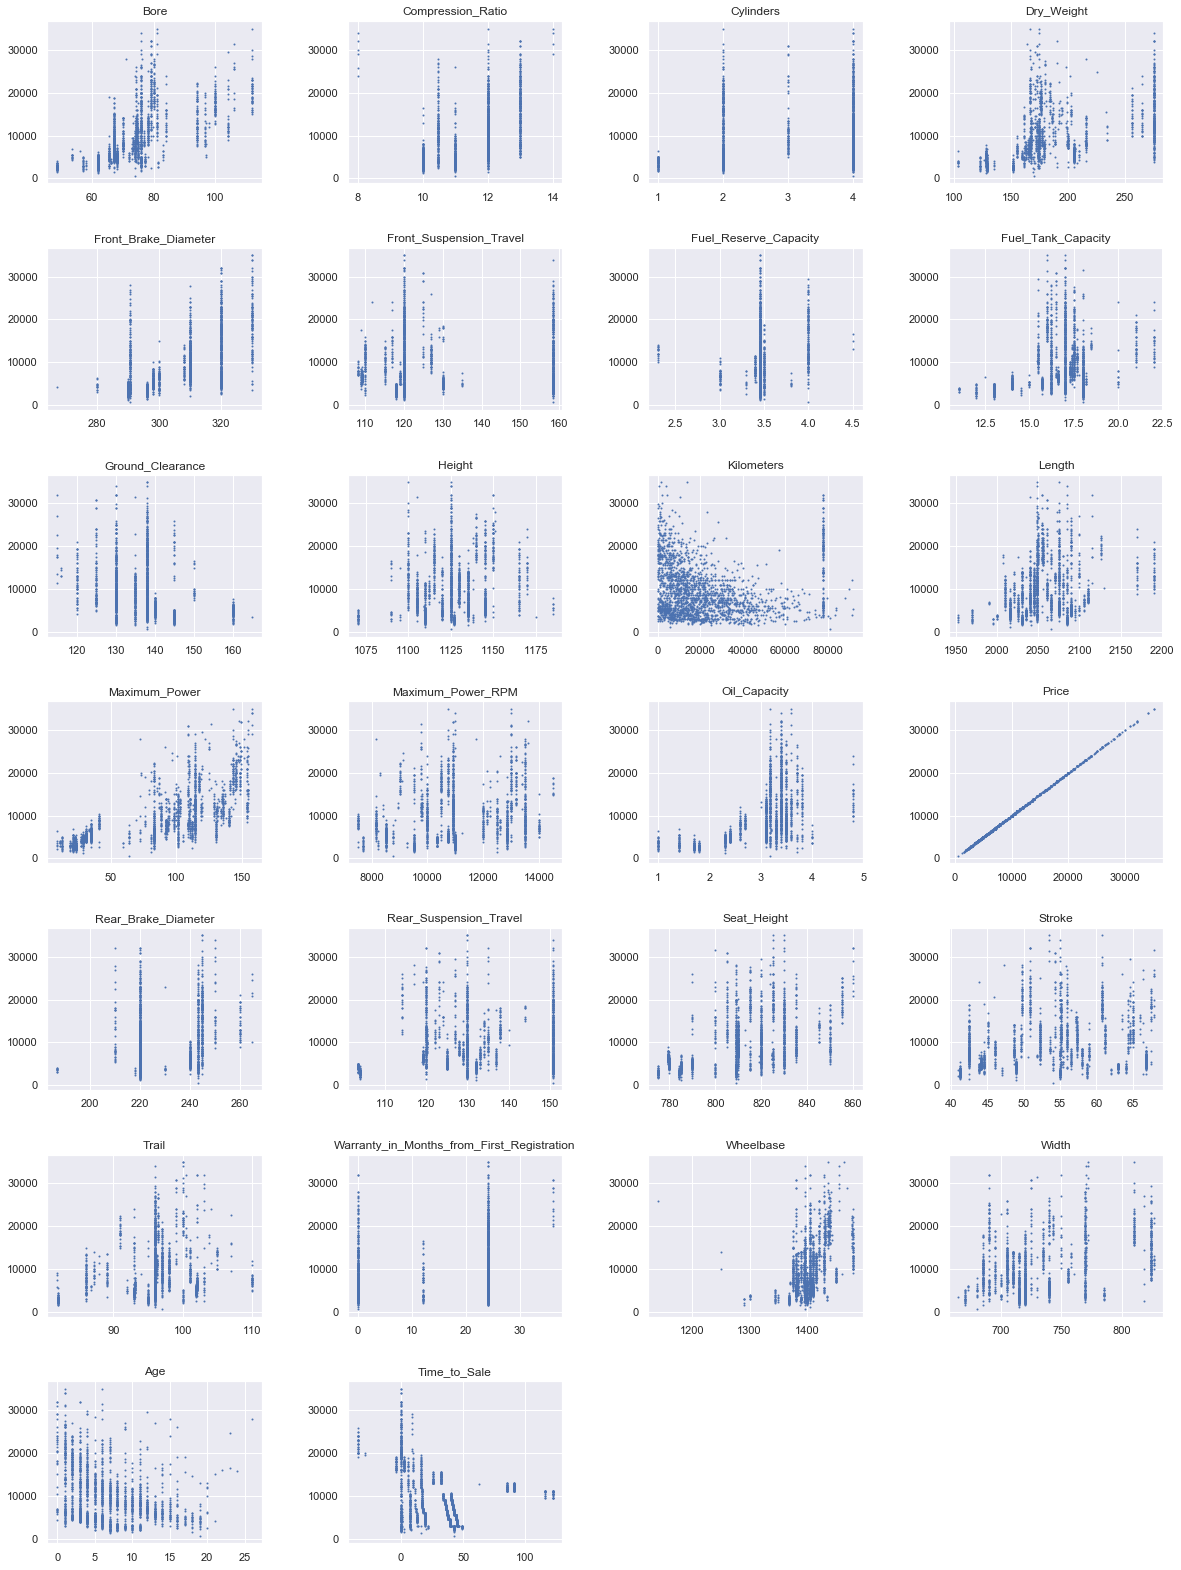

In [109]:
plot_scatter_grid(sport, numerical,col=4)

In [ ]:
# clean outlieers from 
# Compression_Ratio, Front_Brake_Diameter, Front_Suspension_Travel, Reserve_Fuel_capacity

In [ ]:
# Drop
# Engine_voltage